# Recommender Systems Using RBM

Load the necessary libraries.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Load the Data Prepration and Model Evaluation libraries.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Load TensorFlow libraries.

In [3]:
import tensorflow as tf

Load the ratings dataset.

In [4]:
ratings = pd.read_csv('ml-20m/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


Dataset have 4 fields. The user ID, the movie ID, the rating provided by the user for the movie, and the timestamp of the rating provided, now convert the timestamp field into the appropriate format.

In [5]:
ratings.userId = ratings.userId.astype(str).astype(int)
ratings.movieId = ratings.movieId.astype(str).astype(int)
ratings.rating = ratings.rating.astype(str).astype(float)
ratings.timestamp = pd.to_datetime(ratings.timestamp.astype(int), unit='s')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


Let’s find out the number of unique users, unique movies, and total ratings, and also calculate the average number of ratings provided by users.

In [6]:
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]
n_ratings = len(ratings)
avg_ratings_per_user = n_ratings/n_users

print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  138493
Number of unique movies:  26744
Number of total ratings:  20000263
Average number of ratings per user:  144.4135299257002


To reduce the complexity and size of this dataset, let’s focus on the top one thousand most rated movies. This will reduce the number of ratings from about 20 million to about 12.8 million.

In [7]:
movieIndex = ratings.groupby("movieId").count().sort_values(by="rating",ascending=False)[0:1000].index
ratings2 = ratings[ratings.movieId.isin(movieIndex)]
ratings2.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

Let’s take a sample of one thousand users at random and filter the dataset for just these users. This will reduce the number of ratings from ~12.8 million to just 90,213. This number is sufficient to demonstrate collaborative filtering.

In [8]:
userIndex = ratings2.groupby("userId").count().sort_values(by="rating",ascending=False).sample(n=1000, random_state=2018).index
ratings3 = ratings2[ratings2.userId.isin(userIndex)]
ratings3.count()

userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64

Let’s also reindex movieID and userID to a range of 1 to 1,000 for our reduced dataset.

In [9]:
movies = ratings3.movieId.unique()
moviesDF = pd.DataFrame(data=movies,columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1

users = ratings3.userId.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1

ratingDF = ratings3.merge(moviesDF,left_on='movieId',right_on='originalMovieId')
ratingDF.drop(labels='originalMovieId', axis=1, inplace=True)

ratingDF = ratingDF.merge(usersDF,left_on='userId',right_on='originalUserId')
ratingDF.drop(labels='originalUserId', axis=1, inplace=True)

ratingDF.head()

,userId,movieId,rating,timestamp,newMovieId,newUserId
0,49,50,5.0,2013-05-03 02:50:26,1,1
1,49,163,3.5,2013-05-03 02:43:37,2,1
2,49,216,3.0,2013-05-03 02:45:58,3,1
3,49,296,5.0,2013-05-03 02:50:13,4,1
4,49,333,3.0,2013-05-03 02:44:38,5,1


Let’s calculate the number of unique users, unique movies, total ratings, and average number of ratings per user for our reduced dataset.

In [10]:
n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  90213
Average number of ratings per user:  90.213


Let’s generate a test set and a validation set from this reduced dataset so that each holdout set is 5% of the reduced dataset.

In [11]:
X_train, X_test = train_test_split(ratingDF, test_size=0.10, shuffle=True, random_state=2018)
X_validation, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=2018)

Confirm size of train, validation, and test datasets.

In [12]:
print('Size of train set: ', len(X_train))
print('Size of validation set: ', len(X_validation))
print('Size of test set: ', len(X_test))

Size of train set:  81191
Size of validation set:  4511
Size of test set:  4511


Let’s create a matrix m x n, where m are the users and n are the movies. This will be a sparsely populated matrix because users rate only a fraction of the movies.

Generate ratings matrix for train.

In [13]:
ratings_train = np.zeros((n_users, n_movies))
for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[3]

In [14]:
ratings_train.shape

(1000, 1000)

Calculate sparsity of the train ratings matrix.

In [15]:
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 8.12%


Generate ratings matrix for validation.

In [16]:
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]

Generate ratings matrix for test.

In [17]:
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

Calculate sparsity of the validation ratings matrix.

In [18]:
sparsity = float(len(ratings_validation.nonzero()[0]))
sparsity /= (ratings_validation.shape[0] * ratings_validation.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.45%


Define RBM class.

In [19]:
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), self.batchsize),range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

To train the RBM, let’s create a NumPy array called inputX from ratings_train and convert these values to float32. We will also define the RBM to take in a one thousand-dimensional input, output a one thousand-dimensional output, use a learning rate of 0.3, train for five hundred epochs, and use a batch size of two hundred.

In [20]:
#Begin the training cycle
# Convert inputX into float32
inputX = ratings_train
inputX = inputX.astype(np.float32)

# Define the parameters of the RBMs we will train
rbm=RBM(1000,1000,0.3,500,200)

Let’s begin training.

In [21]:
# Train RBM model
err = rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

Epoch: 0 reconstruction error: 1.090690
Epoch: 1 reconstruction error: 1.077044
Epoch: 2 reconstruction error: 1.080472
Epoch: 3 reconstruction error: 1.081750
Epoch: 4 reconstruction error: 1.084983
Epoch: 5 reconstruction error: 1.082221
Epoch: 6 reconstruction error: 1.082191
Epoch: 7 reconstruction error: 1.084332
Epoch: 8 reconstruction error: 1.078475
Epoch: 9 reconstruction error: 1.074733
Epoch: 10 reconstruction error: 1.080264
Epoch: 11 reconstruction error: 1.077209
Epoch: 12 reconstruction error: 1.081915
Epoch: 13 reconstruction error: 1.073771
Epoch: 14 reconstruction error: 1.082952
Epoch: 15 reconstruction error: 1.077198
Epoch: 16 reconstruction error: 1.080096
Epoch: 17 reconstruction error: 1.083670
Epoch: 18 reconstruction error: 1.086246
Epoch: 19 reconstruction error: 1.082517
Epoch: 20 reconstruction error: 1.091434
Epoch: 21 reconstruction error: 1.082924
Epoch: 22 reconstruction error: 1.090487
Epoch: 23 reconstruction error: 1.085794
Epoch: 24 reconstruction e

Epoch: 198 reconstruction error: 1.078918
Epoch: 199 reconstruction error: 1.078897
Epoch: 200 reconstruction error: 1.078984
Epoch: 201 reconstruction error: 1.079234
Epoch: 202 reconstruction error: 1.079002
Epoch: 203 reconstruction error: 1.078025
Epoch: 204 reconstruction error: 1.078984
Epoch: 205 reconstruction error: 1.078781
Epoch: 206 reconstruction error: 1.078601
Epoch: 207 reconstruction error: 1.078797
Epoch: 208 reconstruction error: 1.078848
Epoch: 209 reconstruction error: 1.078928
Epoch: 210 reconstruction error: 1.078779
Epoch: 211 reconstruction error: 1.078362
Epoch: 212 reconstruction error: 1.078140
Epoch: 213 reconstruction error: 1.079069
Epoch: 214 reconstruction error: 1.078465
Epoch: 215 reconstruction error: 1.078434
Epoch: 216 reconstruction error: 1.078164
Epoch: 217 reconstruction error: 1.078114
Epoch: 218 reconstruction error: 1.078511
Epoch: 219 reconstruction error: 1.078331
Epoch: 220 reconstruction error: 1.078166
Epoch: 221 reconstruction error: 1

Epoch: 394 reconstruction error: 1.074255
Epoch: 395 reconstruction error: 1.074561
Epoch: 396 reconstruction error: 1.073691
Epoch: 397 reconstruction error: 1.074335
Epoch: 398 reconstruction error: 1.073722
Epoch: 399 reconstruction error: 1.075008
Epoch: 400 reconstruction error: 1.073758
Epoch: 401 reconstruction error: 1.074484
Epoch: 402 reconstruction error: 1.074340
Epoch: 403 reconstruction error: 1.074579
Epoch: 404 reconstruction error: 1.074592
Epoch: 405 reconstruction error: 1.074520
Epoch: 406 reconstruction error: 1.074293
Epoch: 407 reconstruction error: 1.074710
Epoch: 408 reconstruction error: 1.074481
Epoch: 409 reconstruction error: 1.074646
Epoch: 410 reconstruction error: 1.074271
Epoch: 411 reconstruction error: 1.074782
Epoch: 412 reconstruction error: 1.074455
Epoch: 413 reconstruction error: 1.074579
Epoch: 414 reconstruction error: 1.074486
Epoch: 415 reconstruction error: 1.074455
Epoch: 416 reconstruction error: 1.074260
Epoch: 417 reconstruction error: 1

Displays the plot of the reconstruction errors.

Text(0, 0.5, 'Reconstruction Error')

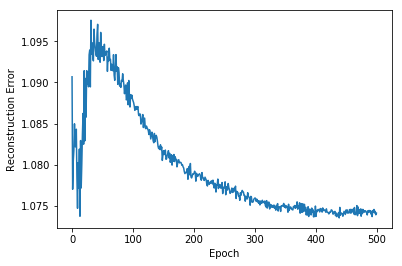

In [22]:
# Plot reconstruction errors
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

Now let’s take the RBM model we developed to predict the ratings for users in the validation set (which has the same users as the training set).

In [23]:
# Predict ratings for validation set
inputValidation = ratings_validation
inputValidation = inputValidation.astype(np.float32)
finalOutput_validation, reconstructedOutput_validation, _ = rbm.rbm_output(inputValidation)

Next, let’s convert the predictions into an array and calculate the MSE against the true validation ratings.

In [24]:
# Calculate MSE on validation set
predictionsArray = reconstructedOutput_validation
pred_validation = predictionsArray[ratings_validation.nonzero()].flatten()
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()
rbm_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using RBM prediction:', rbm_prediction)

Mean squared error using RBM prediction: 9.33246508534693


This MSE is a starting point and will likely improve with greater experimentation.